# Notes about the SAS's Course
# Predictive Modeling Using Logistic Regression (15.1)

This course covers predictive modeling using SAS/STAT software with emphasis on the LOGISTIC procedure. This course also discusses selecting variables and interactions, recoding categorical variables based on the smooth weight of evidence, assessing models, treating missing values, and using efficiency techniques for massive data sets. This notes are based in the course materials, some codes and images are copyrighted by Sas Institute. I made a Jupyter Notebook using JupiterLab with SAS University Edition.

In [2]:
/*Run this script to configurate the session*/

%let InicioCurso=/folders/myfolders/Cursos/EPMLR51;
%include "&InicioCurso/setup.sas";

## Lesson 3: Fitting the Model

#### 3.4 Performing Variable Screening

After you use variable clustering to reduce redundancy, you might still need to do further variable reduction before you use the variable selection techniques in PROC LOGISTIC. Variable screening is an additional way to reduce the number of inputs. Variable screening can also help to detect nonlinear associations so that you can handle them appropriately in PROC LOGISTIC.

#### Detecting Nonlinear Relationships

* Logistic regression was developed for inputs with effects that have a constant rate of change – that is, for inputs that have a linear relationship with the target. 
* When this linear relationship is violated, the predictive accuracy of the model might decrease. 
* One way to detect nonlinear relationships is to plot the logits by the input variable values. 
* Another way to detect problematic nonlinear associations is to use a variable screening method that compares the ranks of the Spearman correlation statistic with the ranks of the Hoeffding's D statistic.
* Spearman correlation statistic looks at the monotonic relationship between the ranks of two variables. The variables must be ordinal or you must be able to treat them as ordinal 
* Spearman is a better choice for this technique because it is less sensitive to nonlinearities and outliers. However, when variables are not monotonically related to each other, the Spearman correlation statistic can miss important associations. 
About the values in both statistics: 
  * When the Spearman rank is high, the association is monotonic, regardless of whether the Hoeffding value is high or low. Monotonic associations are not a problem for the model. 
  * Spearman rank is low and the Hoeffding rank is high, the association is non-monotonic. You should investigate this nonlinear pattern
  * Spearman rank is low and the Hoeffding rank is low, the association is weak. A weak association indicates a clearly irrelevant input that you can eliminate. 

* Even though you have already used variable clustering to reduce redundancy, some further variable reduction might be needed prior to using the variable selection techniques in PROC LOGISTIC. Very liberal univariate screening might be helpful when the number of clusters created in PROC VARCLUS is still relatively large. Because some of the variable selection techniques use the full model, eliminating clearly irrelevant variables (for example, those with p-values greater than .50) will stabilize the full model and might improve the variable selection technique without much risk of eliminating

#### Demo: Performing Variable Screening, Part 1

For the target marketing project, we want to use variable screening to detect nonlinear relationships between the target variable and the input variables. We hope that variable screening will further reduce the number of inputs by identifying those that are clearly irrelevant. We know that it's important to use a very liberal criterion for variable inclusion. In this part of the demonstration, we use the CORR procedure to examine the associations between the inputs chosen from PROC VARCLUS and the target variable. We're going to use the SPEARMAN option to request the Spearman correlation statistic and the HOEFFDING option to request Hoeffding's D statistic. Then we're going to create a table that compares the rank order of the Spearman correlation statistic to the rank order of the Hoeffding's D statistic.


In [1]:
/*the process needs previus executed programs*/

ods select none;

%let InicioCurso=/folders/myfolders/Cursos/EPMLR51/programs;
%include "&InicioCurso/l1_all.sas";
%include "&InicioCurso/l1_demos.sas";
%include "&InicioCurso/l2_all.sas";
%include "&InicioCurso/l2_demos.sas";
%include "&InicioCurso/l3d1.sas";
%include "&InicioCurso/l3d2a.sas";
%include "&InicioCurso/l3d2b.sas";
%include "&InicioCurso/l3d3.sas";
%include "&InicioCurso/l3d4.sas";

ods select all;

SAS Connection established. Subprocess id is 3244



In [22]:
/* ===================================================== */
/* Lesson 3, Section 4:  l3d5a.sas
   Demonstration: Performing Variable Screening, Part 1
   [m643_4_e1; derived from pmlr03d05.sas]               */
/* ===================================================== */

ods select none;
ods output spearmancorr=work.spearman
           hoeffdingcorr=work.hoeffding;

proc corr data=work.train_imputed_swoe spearman hoeffding;
   var ins;
   with &reduced;
run;

ods select all;

proc sort data=work.spearman;
    by variable;
run;

proc sort data=work.hoeffding;
    by variable;
run;

data work.correlations;
   merge work.spearman(rename=(ins=scorr pins=spvalue))
         work.hoeffding(rename=(ins=hcorr pins=hpvalue));
   by variable;
   scorr_abs=abs(scorr);
   hcorr_abs=abs(hcorr);
run;

proc rank data=work.correlations out=work.correlations1 descending;
    var scorr_abs hcorr_abs;
    ranks ranksp rankho;
run;

proc sort data=work.correlations1;
   by ranksp;
run;

title1 "Rank of Spearman Correlations and Hoeffding Correlations";
proc print data=work.correlations1 label split='*';
   var variable ranksp rankho scorr spvalue hcorr hpvalue;
   label ranksp ='Spearman rank*of variables'
         scorr  ='Spearman Correlation'
         spvalue='Spearman p-value'
         rankho ='Hoeffding rank*of variables'
         hcorr  ='Hoeffding Correlation'
         hpvalue='Hoeffding p-value';  
run;



* So we can look at this table, and if the Spearman rank is low, but the Hoeffding rank is high, then the association is probably not monotonic. Empirical logit plots could be used to investigate this type of relationship. So, savings balance has a rank of one for Spearman and one for Hoeffding. That's not a problem. CD: two for Spearman, seven for Hoeffding. Let's see if we see any low ranks for Spearman and high ranks for Hoeffding. Whoa. Here we have checking account balance: 23 for Spearman, three for Hoeffding. I would say checking account balance seems to have a nonlinear relationship with the target. In the next part of the demonstration, we finish the process of variable screening.

#### Demo: Performing Variable Screening, Part 2



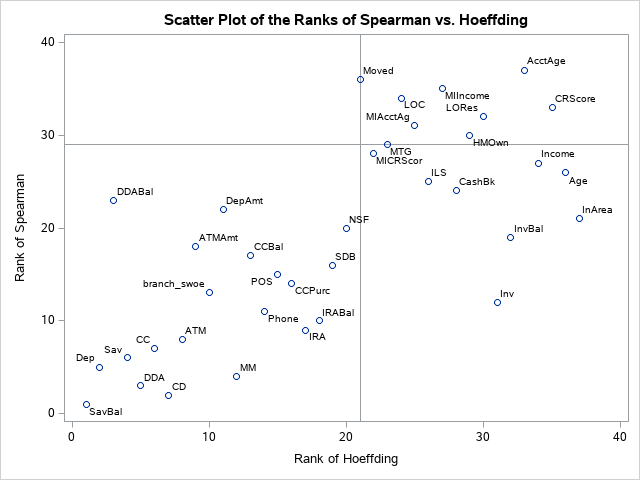

In [23]:
/* ===================================================== */
/* Lesson 3, Section 4: l3d5b.sas
   Demonstration: Performing Variable Screening, Part 2
   [m643_4_e2; derived from pmlr03d05.sas]               */
/* ===================================================== */

/* Find values for reference lines */
%global vref href;
proc sql noprint;
   select min(ranksp) into :vref 
   from (select ranksp 
   from work.correlations1 
   having spvalue > .5);

   select min(rankho) into :href 
   from (select rankho
   from work.correlations1
   having hpvalue > .5);
quit;

/* Plot variable names, Hoeffding ranks, and Spearman ranks. */

title1 "Scatter Plot of the Ranks of Spearman vs. Hoeffding";
proc sgplot data=work.correlations1;
   refline &vref / axis=y;
   refline &href / axis=x;
   scatter y=ranksp x=rankho / datalabel=variable;
   yaxis label="Rank of Spearman";
   xaxis label="Rank of Hoeffding";
run;
title1 ;

%global screened;
%let screened=SavBal Dep DDA CD Sav CC ATM MM branch_swoe Phone IRA IRABal 
              DDABal ATMAmt ILS POS NSF CCPurc SDB DepAmt CCBal Inv InArea   
              Age CashBk MICRScor Income;

In general, the upper right corner of the plot contains the names of variables that could reasonably be excluded from further analysis, due to their poor rank on both metrics. The criterion to use in eliminating variables is a subjective decision. Thus nine variables are eliminated from our analysis.
In addition to being a useful screening tool, this analysis might point towards further analyses. Low ranks for Spearman and high ranks for Hoeffding are found for the variables checking account balance, deposit amount, and ATM amount. Even though these variables do not have a monotonic relationship with Ins, some other type of relationship is detected by Hoeffding's D statistic. An empirical logit plot should be used to examine these relationships.


#### Practice: Performing Variable Screening
For the veterans' organization project, use the Spearman and Hoeffding correlation coefficients to screen the inputs in the training data set. You are looking for inputs that have a strong nonlinear relationship or a weak relationship with the target.

Note: If you started a new SAS session after you performed the previous practice, do the following before you continue:

Make sure you have set up your practice files in the Course Overview.
Open l3_all.sas. It contains the solution code for all practices in Lesson 1, 2, and 3. Locate the code for the previous practice(s), review the comments to see if any modifications are needed, and then submit the code.
Open l3p5.sas in your SAS software. The %LET statement creates the ex_reduced macro variable, which stores a list of the input variables that were selected from the pmlr.pva_train_imputed_swoe data set in the previous practice.


In [28]:
%let InicioCurso=/folders/myfolders/Cursos/EPMLR51/programs;
%include "&InicioCurso/l3p5.sas";

Write a PROC CORR step that does the following:
creates Spearman and Hoeffding correlations of the input variables that were selected from variable clustering (in the previous practice) with the target variable
specifies the inputs by referencing the ex_reduced macro variable that you created in the previous step
uses the ODS OUTPUT statement to create two temporary data sets: a data set named work.spearman from the spearmancorr output object, and a data set named work.hoeffding from the hoeffdingcorr output object

Add the following ODS statements:
Before the ODS OUTPUT statement, add an ODS SELECT NONE statement to suppress output to the open ODS destination.
Following the PROC CORR code, add an ODS SELECT ALL statement to resume sending output to the open ODS destination.

In [27]:
ods select none;
ods output spearmancorr=work.spearman
           hoeffdingcorr=work.hoeffding;

proc corr data=pmlr.pva_train_imputed_swoe 
          spearman hoeffding;
   var target_b;
   with &ex_reduced;
run;

ods select all;

How many observations and variables does the work.spearman data set have?
The log indicates that the work.spearman data set has 28 observations and three variables.

Merge the work.spearman and work.hoeffding data sets by the variable named Variable and name the merged data set work.correlations.

In the DATA step, do the following:
Rename the Spearman correlation statistic as Scorr, the Spearman p-value as Spvalue, the Hoeffding correlation statistic as Hcorr, and the Hoeffding p-value as Hpvalue.
Create the two new variables, Scorr_Abs and Hcorr_Abs, that represent the absolute values of the Spearman correlation statistics and the Hoeffding correlation statistics, respectively.

In [29]:
proc sort data=work.spearman;
    by variable;
run;

proc sort data=work.hoeffding;
    by variable;
run;

data work.correlations;
   attrib variable length=$32;
   merge work.spearman(rename=
         (target_b=scorr ptarget_b=spvalue))
         work.hoeffding
         (rename=(target_b=hcorr ptarget_b=hpvalue));
   by variable;
   scorr_abs=abs(scorr);
   hcorr_abs=abs(hcorr);
run;

How many observations and variables are in the work.correlations data set?
The log indicates that the work.correlations data set has 28 observations and seven variables.

Write a PROC RANK step that does the following:
creates the ranks of the correlation coefficients
reverses the direction of the ranks so that the highest correlation has a rank of 1
creates a data set named work.correlations1
specifies the absolute values of the Spearman and Hoeffding correlation statistics in the VAR statement
creates the two new variables RankSp (for the rank of the Spearman correlation statistic) and RankHo (for the rank of the Hoeffding correlation statistic)

In [30]:
proc rank data=work.correlations 
          out=work.correlations1 descending;
    var scorr_abs hcorr_abs;
    ranks ranksp rankho;
run;

The log indicates that the work.correlations1 data set has 28 observations and nine variables.

Sort the work.correlations1 data set by the rank of Spearman, and then print it.

In [31]:
proc sort data=work.correlations1;
   by ranksp;
run;

title1 "Rank of Spearman Correlations and Hoeffding Correlations";
proc print data=work.correlations1 label split='*';
   var variable ranksp rankho scorr spvalue hcorr hpvalue;
   label ranksp='Spearman rank*of variables'
         scorr='Spearman Correlation'
         spvalue='Spearman p-value'
         rankho='Hoeffding rank*of variables'
         hcorr='Hoeffding Correlation'
         hpvalue='Hoeffding p-value';
run;

Which variable has the highest rank for Spearman?
Which variable has the highest rank for Hoeffding?
The results indicate the following:
The variable with the highest Spearman rank is Frequency_Status_97NK.
The variable with the highest Hoeffding rank is Frequency_Status_97NK.


Write a PROC SQL step that creates macro variables that point to the smallest Spearman rank and Hoeffding rank associated with a p-value greater than 0.5.

Add a PROC SGPLOT step that creates a scatter plot of the ranks of Spearman versus the ranks of Hoeffding. Label the points with the variable name. Use REFLINE statements to create vertical and horizontal reference lines on the plot.


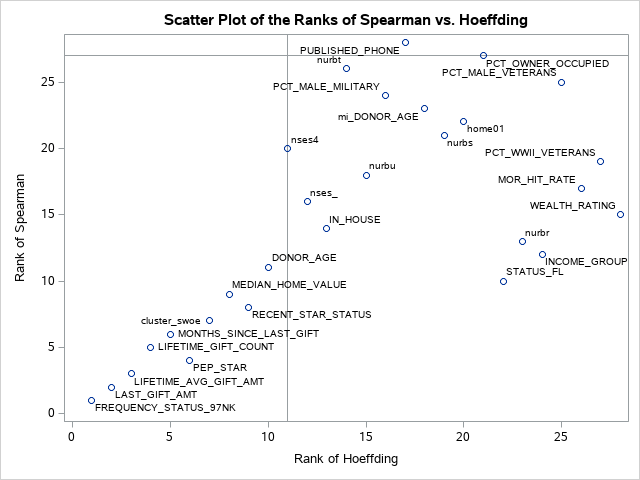

In [32]:
%global vref href;
proc sql noprint;
   select min(ranksp) into :vref 
   from (select ranksp 
         from work.correlations1 
         having spvalue > .5);
   select min(rankho) into :href 
   from (select rankho
         from work.correlations1
         having hpvalue > .5);
quit;

title1 "Scatter Plot of the Ranks of Spearman vs. Hoeffding";
proc sgplot data=work.correlations1;
   refline &vref / axis=y;
   refline &href / axis=x;
   scatter y=ranksp x=rankho / datalabel=variable;
   yaxis label="Rank of Spearman";
   xaxis label="Rank of Hoeffding";
run;

Do any input variables show evidence of a nonlinear relationship with the target?
Can any input variables be eliminated due to irrelevancy?

The results indicate the following:
None of the variables shows evidence of a nonlinear relationship with the target. There are no variables in the top left corner of the graph, which corresponds to a high rank of Hoeffding and a low rank of Spearman. (Remember that a high rank is a low number.)
The input variables Pct_Owner_Occupied and Published_Phone can be eliminated due to irrelevancy.

#### Univariate Binning and Smoothing

* it is standard practice to look for nonlinear relationships between each input and the target by examining scatter plots. 
* A plot of the empirical logits, like the one on the right, can be useful to detect nonlinear relationships. 
* To create an empirical logit plot, you transform Y into the logit by using the log of p over 1-p. In the empirical logit plot, the Y axis is the logit axis. 
* The relationship between X and the logit is clear; it's a nonlinear relationship that you might call approximately quadratic.

* For continuous inputs, you need to bin your X values because there are too few cases for each unique value of X. 
* Therefore, you bin the X values into intervals, and then, within the interval, you can obtain the observed proportion of the target event cases and total cases. 
* For binary inputs, it's a waste of time to create empirical logit plots. You'll get a straight line between two points.

There is one problem with logit plots. When p=1 or 0, the logit is infinite. To solve the problem of infinite logits, you calculate a smooth estimate by adding a positive term in both the numerator and the denominator of the empirical logit formula. The smoothing term in the numerator and denominator is the square root of uppercase Mi (the number of cases) divided by 2. The smoothing term uses a minimax estimate of the proportion of events in each bin (Duffy and Santner 1989). This smoothing method eliminates the problem caused by zero counts, and reduces variability. The number of bins determines the amount of smoothing. For example, fewer bins mean more smoothing. One large bin would give a constant logit. 
* For very large data sets and intervally scaled inputs, 100 bins often work well. 
* If the standard logistic model were true, then the plots should be linear. Sample variability can cause apparent deviations, especially when the bin size is too small. But serious nonlinearities, such as nonmonotonic relationships, are usually easy to detect.

#### Demo: Creating Empirical Logit Plots

* For the target marketing project, we want **to look for nonlinear relationships between the input variables and the target variable** in the training data set. In the last demonstration, we discovered that checking account balance, that is, DDABal, has a nonlinear relationship with the target.
* We generate empirical logit plots to visualize the nonlinear relationship. 
 * Bin the values of checking account balance using PROC RANK. 
 * Calculate the empirical logit values using PROC MEANS and a DATA step.
 * create empirical logit plots using PROC SGPLOT. 


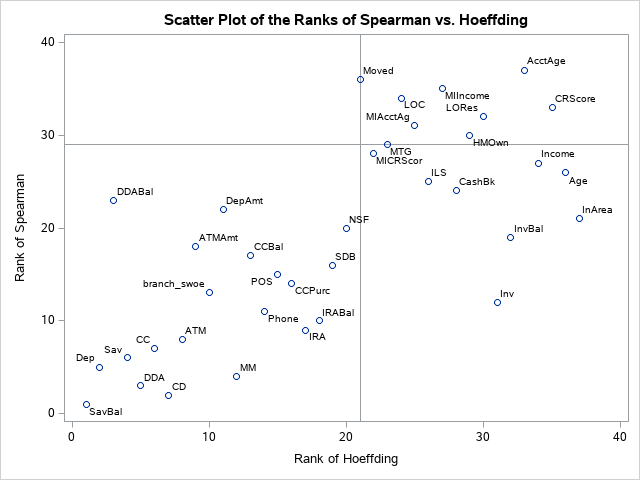

In [3]:
/*the process needs previus executed programs*/

ods select none;

%let InicioCurso=/folders/myfolders/Cursos/EPMLR51/programs;
%include "&InicioCurso/l1_all.sas";
%include "&InicioCurso/l1_demos.sas";
%include "&InicioCurso/l2_all.sas";
%include "&InicioCurso/l2_demos.sas";
%include "&InicioCurso/l3d1.sas";
%include "&InicioCurso/l3d2a.sas";
%include "&InicioCurso/l3d2b.sas";
%include "&InicioCurso/l3d3.sas";
%include "&InicioCurso/l3d4.sas";
%include "&InicioCurso/l3d5a.sas";
%include "&InicioCurso/l3d5b.sas";

ods select all;


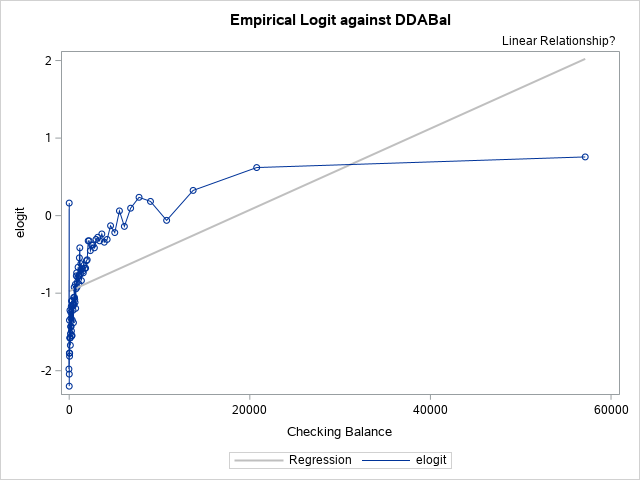
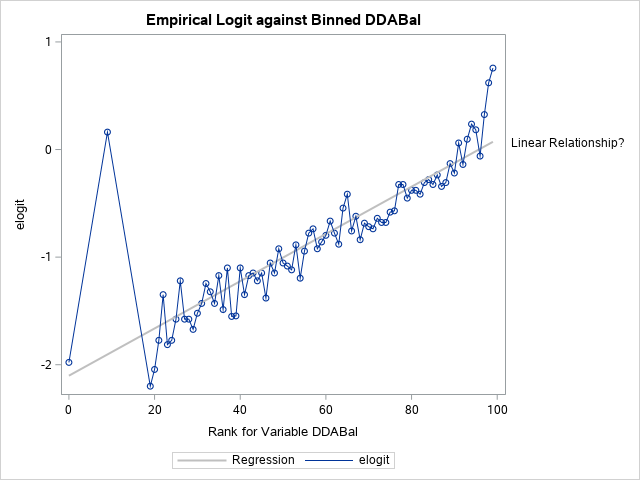

In [4]:
%global var;
%let var=DDABal;

/* Group the data by the variable of interest in order to create 
   empirical logit plots.   */

proc rank data=work.train_imputed_swoe groups=100 out=work.ranks;
   var &var;
   ranks bin;
run;

title1 "Checking Account Balance by Bin";
proc print data=work.ranks(obs=10);
   var &var bin;
run;

/* The data set BINS will contain:INS=the count of successes in each bin,
   _FREQ_=the count of trials in each bin, DDABAL=the avg DDABAL in each bin. */

proc means data=work.ranks noprint nway;
   class bin;
   var ins &var;
   output out=work.bins sum(ins)=ins mean(&var)=&var;
run;

title1 "Number of Observations, Events, and Average Checking Account Balance by Bin";
proc print data=work.bins(obs=10);
run;

/* Calculate the empirical logit */ 

data work.bins;
   set work.bins;
   elogit=log((ins+(sqrt(_FREQ_ )/2))/
          ( _FREQ_ -ins+(sqrt(_FREQ_ )/2)));
run;

title1 "Empirical Logit against &var";
proc sgplot data=work.bins;
   reg y=elogit x=&var /
       curvelabel="Linear Relationship?"
       curvelabelloc=outside
       lineattrs=(color=ligr);
   series y=elogit x=&var;
run;

title1 "Empirical Logit against Binned &var";
proc sgplot data=work.bins;
   reg y=elogit x=bin /
       curvelabel="Linear Relationship?"
       curvelabelloc=outside
       lineattrs=(color=ligr);
   series y=elogit x=bin; 
run;


#### Practice: Creating Empirical Logit Plots
For the veterans' organization project, create empirical logit plots to investigate the nonlinear relationship between the input Last_Gift_Amount and the bins of Last_Gift_Amount, respectively, with the target (Target_B).

Write code that bins the Last_Gift_Amt variable in the pmlr.pva_train_imputed_swoe data set. Create a macro variable to store the variable name Last_Gift_Amt. In PROC RANK, specify 20 groups and create an output data set named work.ranks.

In [5]:
%global var;
%let var=LAST_GIFT_AMT;

proc rank data=pmlr.pva_train_imputed_swoe 
          groups=20 out=work.ranks;
   var &var;
   ranks bin;
run;


The work.ranks data set has 9687 observations and 66 variables.
To compute the logits and add them to the work.bins data set, use PROC MEANS and the DATA step.

In [6]:
proc means data=work.ranks noprint nway;
   class bin;
   var target_b &var;
   output out=work.bins sum(target_b)=target_b 
          mean(&var)=&var;
run;

data work.bins;
   set work.bins;
   elogit=log((target_b+(sqrt(_FREQ_ )/2))/
          ( _FREQ_ -target_b+(sqrt(_FREQ_ )/2)));
run;


The work.bins data set has 16 observations and six variables.
Create an empirical logit plot of Last_Gift_Amt versus Target_B.


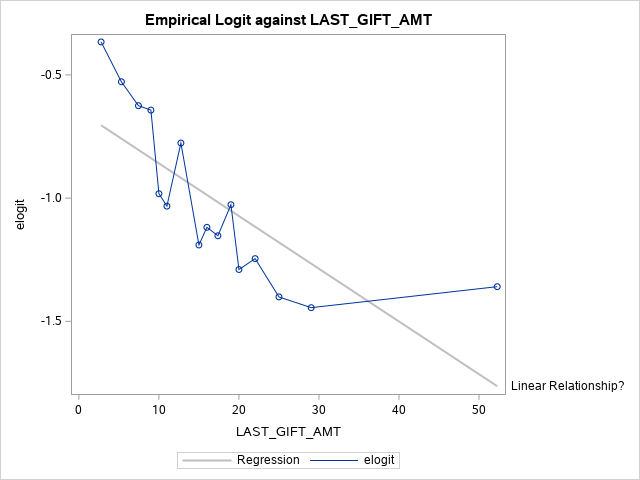

In [7]:
title1 "Empirical Logit against &var";
proc sgplot data=work.bins;
   reg y=elogit x=&var /
       curvelabel="Linear Relationship?"
       curvelabelloc=outside
       lineattrs=(color=ligr);
   series y=elogit x=&var;
run;
title1;

The logit plot shows evidence of a negative linear relationship.
Create an empirical logit plot of the bins of Last_Gift_Amt versus Target_B.

What is the relationship between the ranks of Last_Gift_Amt and the target?


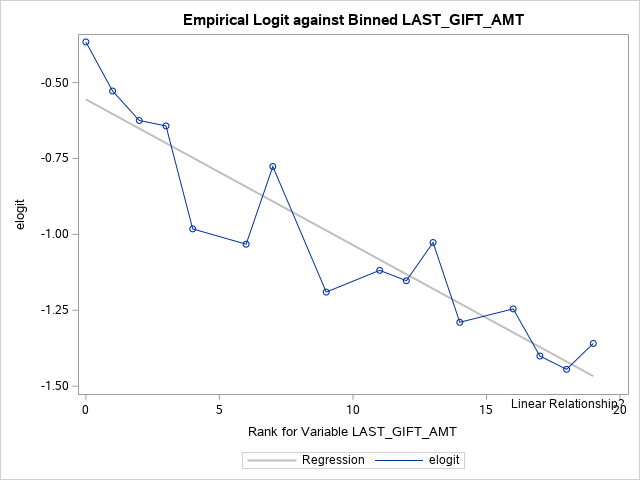

In [9]:
title1 "Empirical Logit against Binned &var";
proc sgplot data=work.bins;
   reg y=elogit x=bin /
       curvelabel="Linear Relationship?"
       curvelabelloc=outside
       lineattrs=(color=ligr);
   series y=elogit x=bin;
run;
title1;

The logit plot shows evidence of a negative linear relationship.

#### Remedies for Nonlinear Relationships
One remedy is to **create hand-crafted, new input variables** by transforming or discretizing the original inputs. When you create groups, you can use them in a CLASS statement. The CLASS statement can handle any type of relationship. This approach requires skill and patience. This approach also increases the risk of overfitting.

Another possible way to handle nonlinear effects is to **use a polynomial model**; you can add quadratic and cubic terms. For example, the empirical logit plot shown here indicates a quadratic relationship between the target and the input variable. A polynomial model might improve model fit but is more difficult to interpret and generalize. Also, be aware that higher-order polynomials are not reliable smoothers. In other words, higher-order polynomials exaggerate the effects of the peculiarities in the data.

**A multivariate function estimator** can be a flexible alternative to logistic regression. 
* Examples: classification trees, generalized additive models, and neural networks. Additional examples include projection pursuit, multivariate adaptive regression splines, radial basis function networks, and multilayer perceptrons (Hastie and Tibshirani 1990, Ripley 1996).

Finally, just **continue using standard logistic regression**. Standard logistic regression is a robust model that can produce accurate predictions even when there are substantial nonlinear relationships between the target and the input variables. 

If time permits, you can increase the predictive accuracy of the model by doing various modifications that can accommodate the nonlinear relationships.

#### Practice 7: Accommodating a Nonlinear Relationship, Part 1

In the previous demonstration, it seemed suspicious that a large portion of the population has exactly zero dollars in their checking accounts. Suppose we found out that most customers with zero balances do not have checking accounts. Their balances were set to zero when the original develop data set was created, and this caused a nonlinear relationship that we saw in the empirical logit plot. To linearize the relationship between checking account balance and the target, we will reimpute the checking account balance values for customers who have no checking accounts.

In this part of the demonstration, we do the following: 
* For customers who have checking accounts, create a macro variable that has the mean value of the checking account balance. 
* For customers with no checking accounts, replace the checking account balance with the mean in the macro variable. 
* Generate empirical logit plots to verify that the relationship is now linear.

In [10]:
title1 "Checking Account Balance and INS by Checking Account";
proc means data=work.train_imputed_swoe mean median min max;
   class dda;
   var ddabal ins;
run;
title1 ;

Well, first, we have PROC MEANS. Data= our training data set, and we'll generate the mean, median, minimum, and maximum values. class dda; (So we're looking at each level of Dda.) Checking account versus no checking account.

var ddabal ins; (So, for each level of Dda, we'll look at the checking account balance and ins-- the target variable.) Let's submit that code.

From the output, it is clear that the individuals without checking accounts have had zero balances imputed and those individuals respond at a higher rate than individuals with checking accounts. For people without checking accounts, 54% bought the variable annuity product while, for people with checking accounts, 30% bought the variable annuity product. If this seems unreasonable, consider that the individuals without checking accounts presumably do their everyday banking with a different bank altogether and treat this bank as an investment institution. There are several possible ways to account for this discrepancy between the checking account balance value and the empirically observed response behavior. One of the most straightforward is to reimpute.

We're going to show you code that creates a macro variable mean that has the value of the checking account balances of those customers who actually have checking accounts. Then the mean is substituted for the zero balances of those who do not have checking accounts.

So here, I have %global mean; proc sql...; with the NOPRINT option. Select the mean checking account balance, and we're going to create a macro variable called mean from our training data set where dda equals 1 or people have checking accounts. Let's submit that code.

The following DATA step fills in the zero balances with the balance of customers who have their accounts at this bank. So here, we have the DATA step creating a new data set called work.train_imputed_swoe_dda. Bringing in the training data set... If not dda, then ddabal equals the mean. So if they do not have a checking account, they will now have a balance that's equal to the mean of the people who have checking accounts.

In [11]:
/* A possible remedy for that non-linearity is to replace the logical 
   imputation of 0 for non-DDA customers with the mean. */

%global mean;
proc sql noprint;
   select mean(ddabal) into :mean 
   from work.train_imputed_swoe where dda;
quit;

data work.train_imputed_swoe_dda;
   set work.train_imputed_swoe;
   if not dda then ddabal=&mean;
run;

To evaluate the effectiveness of this reimputation, let's take another look at the empirical logit plots.

So %global var; %let var=DDABal; Then we have the PROC RANK. Again, we are binning checking account balance into 100 groups. We're creating an output data set called work.ranks.

The variable to be binned is checking account balance. Creating a variable called Bin... That's our group membership number.

Using PROC MEANS to create an output data set called work.bins, and we are summing Ins to come up with the number of events and come up with the mean for checking account balance. So let's submit the code up to PROC MEANS.

The DATA step to create the empirical logit. Let's submit the DATA step.

In [12]:
/* Create new logit plots */
%global var;
%let var=DDABal;

proc rank data=work.train_imputed_swoe_dda groups=100 out=work.ranks;
   var &var;
   ranks bin;
run;

proc means data=work.ranks noprint nway;
   class bin;
   var ins &var;
   output out=work.bins sum(ins)=ins mean(&var)=&var;
run;

Now, let's generate the first empirical logit plot looking at the empirical logits by the mean for checking account balance. So we have our PROC SGPLOT code. Let's submit that code.

It still doesn't look linear, does it? It's still got the spike, and it still has a quadratic relationship.

Let's see if plotting the empirical logits by bin is any better. So again, we're plotting empirical logits by the percentile of the checking account balance. Let's submit the PROC SGPLOT code.

That looks much better. The bins do a very good job of capturing the way that response behavior changes with respect to checking account balances in a fairly linear way. It's a beautiful linear relationship. In the next part of the demonstration, we finish the process of linearizing the relationship.


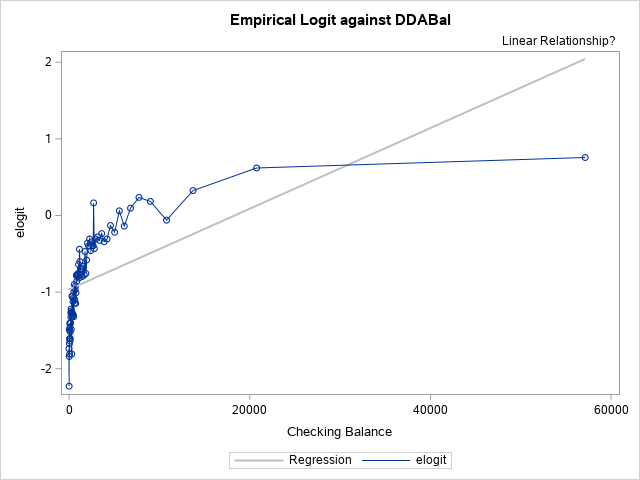
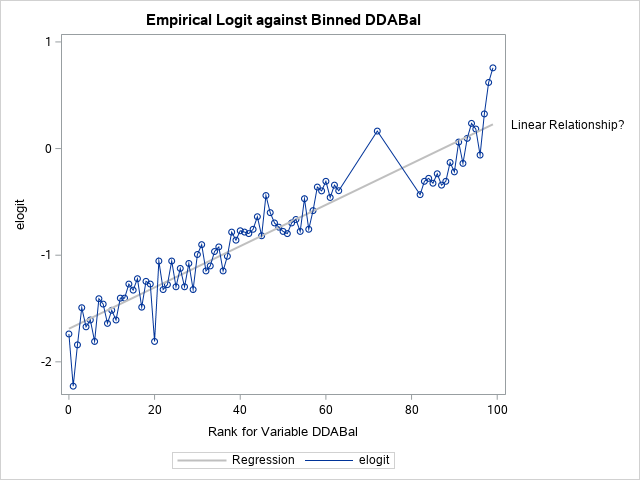

In [13]:
/* Calculate the empirical logit */ 
data work.bins;
   set work.bins;
   elogit=log((ins+(sqrt(_FREQ_ )/2))/
          ( _FREQ_ -ins+(sqrt(_FREQ_ )/2)));
run;

title1 "Empirical Logit against &var";
proc sgplot data=work.bins;
   reg y=elogit x=&var /
       curvelabel="Linear Relationship?"
      curvelabelloc=outside
      lineattrs=(color=ligr);
   series y=elogit x=&var;
run;

title1 "Empirical Logit against Binned &var";
proc sgplot data=work.bins;
   reg y=elogit x=bin /
       curvelabel="Linear Relationship?"
       curvelabelloc=outside
       lineattrs=(color=ligr);
   series y=elogit x=bin;  
run;

#### Accommodating a Nonlinear Relationship, Part 2
we finish linearizing the relationship between the checking account balance and the target in the training data set. We do the following: 
* Create a set of rules that bins all the values of checking account balance, and store the score code in a file. 
* Create a binned checking account variable in the training data set by using the score code in a DATA step, and 
* replace the old input variable, DDABal, with the bin input variable, B_DDABal, in the screened macro variable.

The RANK procedure assigns observations to 100 groups according to checking account balance. Then we have PROC RANK, our training data set, groups=100. Create an output data set called work.ranks. var ddabal; so we're binning checking account balance. ranks bin... Bin will be the variable that indicates our group membership number.

In [14]:
proc rank data=work.train_imputed_swoe_dda groups=100 out=work.ranks;
   var ddabal;
   ranks bin;
run;

PROC MEANS creates a data set that contains the maximum checking account balance value in each bin. This information can be used to assign a new data set its own bins without running the PROC RANK.

So we have PROC MEANS. Data= the output data set from PROC RANK. Use the NOPRINT option and the NWAY option. class bin; var ddabal; output out=endpts max=max; So we're looking at the max checking account balance for each bin and creating an output data set called endpts.

And we have a PROC PRINT to show you what the data set work.endpts looks like.

Let's submit that code.



In [15]:
/* Save the endpoints of each bin */

proc means data=work.ranks noprint nway;
   class bin;
   var ddabal;
   output out=endpts max=max;
run;

title1 "Checking Account Balance Endpoints";
proc print data=work.endpts(obs=10);
run;

So for bin 0, the maximum checking account balance is 1.75. For bin 1, it's 8.45. For bin 2, 16.44, et cetera.

Binning the values requires a set of rules like the following. If DDABal is less than or equal to 1.75, then bin equals 0. Instead of writing these rules by hand, we use the DATA step to write the rules for us.

An easy way to do this is to use a FILENAME statement to point to a file and then write the rules to that file using the PUT statement. So here's our FILENAME statement, and we're creating a fileref called rank, which points to the physical file. In my PMLR folder, it's pointing to rank.sas, and we have a data _null_; file rank; so the FILE statement specifies where you want to put the output of the DATA step.

set work.endpts end=last; so the SET statement brings in the data set endpoints, which has the maximum balance in each bin, and the option END= creates an internal flag that you can use to identify the last record of the data set.

if _n_=1 (so for the first iteration) then put "select;";

if not last (so if not the last record) then do; put " when (ddabal is less than or equal to " max ) then DDABal equals the bin. The end goes with the DO loop. else if (it's the) last (record) then do; put " otherwise B_DDABal equals " the bin. And put "end; ". And the end goes with the DO loop.

So essentially this DATA step creates a set of rules to assign each observation a bin.

In [16]:
/* Write the code to assign individuals to bins according to the DDABal. */

filename rank "&PMLRfolder/rank.sas";

data _null_;
   file rank;
   set work.endpts end=last;
   if _n_=1 then put "select;";
   if not last then do;
      put "  when (ddabal <= " max ") B_DDABal =" bin ";";
   end;
   else if last then do;
      put "  otherwise B_DDABal =" bin ";" / "end;";
   end;
run;

We'll submit the FILENAME statement and the DATA step, and let's look at rank.sas. This is what we created: select; when checking account balance is less than or equal to 1.75, bin checking account balance equals 0.

When checking account balance is less than or equal to 8.45, bin checking account balance equals 1, et cetera, all the way to the last row, where it says, otherwise bin checking account balance equals 99. So if all the other statements are not true, you're in bin 99.

To bring the rank.sas code into our program, we use a %INCLUDE statement embedded in a DATA step. So this DATA step puts B_DDABal on the imputed data set. The SOURCE option requests that the code be included in the log as well.

So there's %INCLUDE rank, so we're bringing in rank, and run. So let's run this DATA step.

And now to see that the recoding worked, evaluate the minimum and maximum checking account balances in each of the bins. We're going to use PROC MEANS with a CLASS statement to do this. proc means data= your new training data set. Let's look at the min and the maximum values for each bin checking account balance, for the variable checking account balance. Let's submit that code.

So for bin 0, the checking account balance went from negative 774 to 1.75. For bin 1, it went from 1.89 to 8.45. Bin 2 went from 8.46 to 16.44.

And let's see where all our friends who had zero checking account balances ended up. Remember, we reimputed those to the mean.

Here they are. They're now in bin 72. Before, they were in bin 9, and of course, their min and max is the same at 2,713.

Because the bin balance input is a replacement for the checking account balance column, let's switch B_DDABal for DDABal in the screened macro variable. %GLOBAL screened; Make it a global macro variable. The %LET statement has an updated list of variables to be included in the screened macro variable.

The bin checking account balance, B_DDABal, replaces DDABal.

In [17]:
/* Use the code. */

data work.train_imputed_swoe_bins;
   set work.train_imputed_swoe_dda;
   %include rank / source;
run;

title1 "Minimum and Maximum Checking Account Balance by Bin";
proc means data=work.train_imputed_swoe_bins min max;
   class B_DDABal;
   var DDABal;  
run;
title1 ;

/* Switch the binned DDABal (B_DDABal) for the originally scaled 
   DDABal input in the list of potential inputs. */
%global screened;
%let screened=SavBal Dep DDA CD Sav CC ATM MM branch_swoe Phone IRA
              IRABal B_DDABal ATMAmt ILS POS NSF CCPurc SDB DepAmt
              CCBal Inv InArea Age CashBk MICRScor Income;

### 3.5 Selecting Variables Sequentially

An important part of data preparation is selecting the most predictive variables for your model. In regression, variable-selection methods are concerned with finding subsets of the inputs that are jointly important in predicting the target. By choosing a sequential selection method, you can increase the accuracy of your model and reduce its complexity.

#### Specifying a Subset Selection Method in PROC LOGISTIC
In PROC LOGISTIC, you specify a subset-selection method in the MODEL statement by using the SELECTION= option. The subset selection methods are also referred to as model-selection methods and effect-selection methods. In this lesson, you'll learn about three methods of subset selection: the best-subsets selection method (which is also called all-subsets selection), stepwise selection, and backward elimination. For best-subsets selection, you specify SELECTION=SCORE; for stepwise selection, you specify SELECTION=STEPWISE; and for backward elimination, you specify SELECTION=BACKWARD. By default, SELECTION=NONE.

To change the default settings for the subset selection methods, you can also specify effect selection options. For example, the backward elimination method uses the significance level of the Wald chi-square to determine whether an effect stays in the model. The SLSTAY= option specifies the value of the significance level for an effect to stay in the model. The default value of the SLSTAY= option is .05. To specify a different significance level for an effect to stay in the model, you specify a value of the SLSTAY= option between 0 and 1, inclusive.

The stepwise selection method also uses the significance level of the Wald chi-square to determine whether an effect enters the model. The SLENTRY= option specifies the value of the significance level for an effect to enter the model. The default value of the SLENTRY= option is .05. To specify a different significance level for an effect to enter the model, you specify a value of the SLENTRY= option between 0 and 1, inclusive.

#### Best-Subsets Selection
The subset selection method that does the most thorough search of the input variables is the best-subsets selection method. This method considers all possible models and rank-orders them based on the score chi-square. Suppose you're working with three inputs. The first possible subset contains all of the variables. Then there are three possible two-variable models, which are ranked by the score chi-square, and three possible one-variable models, which are also ranked by the score chi-square. The last possible subset contains no variables. So, what's the problem with best-subsets selection? For the total number of inputs, k , there are 2k possible subsets to consider. If you're working with a large number of inputs, the best-subsets selection method becomes prohibitively expensive with respect to computer resources.

#### Stepwise Selection
Stepwise variable selection is an often criticized and yet heavily used subset selection method. Stepwise selection is a method of subset selection that starts with an empty model. This method adds inputs incrementally until no more inputs meet the entry criterion for statistical significance. As variables are sequentially added to the model, previously selected variables are also evaluated, and are removed if they do not meet the criterion to stay in the model. The usual criteria used to add or remove inputs from the model are based on the p-value from a test of the null hypothesis that the parameter estimate for a variable is zero. Remember that the **SLENTRY= option specifies the criterion for entry** and the **SLSTAY= option specifies the criterion for removal**. Note that in subset selection, the p-value is merely a tuning parameter that measures the relative strength of the candidate variables.

Let's look at an example. The total number of inputs to be considered is 12. The p-value for the entry criterion is .05, which is the default in PROC LOGISTIC. In the first step, this method evaluates all one-input variable models, and selects the variable with the smallest p-value that is less than .05. X5 meets the criterion and is added to the model. At step 2, stepwise selection evaluates all remaining 11 variables. The second variable added to the one-input variable model is the one with the smallest p-value. In this case, the variable is X9. At step 3, the same process results in the selection of X6 as the third variable. At step 4, the variable X12 is added. At step 5.... Wait a minute, what happened? After variable X12 was added in step 4, the test statistics for all the previously selected variables were recalculated. The variable X6 no longer met the criterion to stay in the model—the SLSTAY significance level—so it was removed. In step 6, the variable X8 is found to meet the entry criterion, so it is added to the model. Finally, the variable X1 is found to meet the criterion for entry, and is added to the model. At this point, the five variables that have entered the model meet the criterion to stay. There are no remaining variables that meet the criterion for entry, so the process stops.

So, are there any problems with stepwise selection? **Stepwise selection does not give good results when there is a high degree of redundancy**. If you don't reduce redundant variables, you might have high multicollinearity, and unstable parameter estimates and p-values. Therefore, the final model might not have the best predictive variables. Stepwise selection was devised to give a computationally efficient alternative to examining all subsets. It is not guaranteed to find the best subset and it can be shown to perform badly in many situations (Harrell 1997).

#### Backward Elimination
Backward elimination is a method of subset selection that starts with a full model. At each step, the test statistics are computed, and the variable with the largest p-value that exceeds the SLSTAY criterion is removed from the model. In this example, the full model consists of 12 variables and the SLSTAY p-value is .05. At step 1, X2 has the largest p-value and does not meet the SLSTAY criterion, so X2 is removed from the model. At step 2, X11 is removed. At step 3, X4 is removed. At step 4, X10 is removed. At step 5, X7 is removed. At step 6, X3 is removed. At step 7, X6 is removed. The five variables that remain in the model have p-values smaller than the SLSTAY criterion, so they remain. The process stops here.

How does backward selection compare to other sequential selection methods? **Backward elimination is less inclined to exclude important inputs or include spurious inputs than forward methods**, such as stepwise selection (Mantel 1970; Harrell 1997). Backward elimination is considered more computationally expensive than stepwise because more steps are usually required and they involve larger models. However, backward elimination does have a few problems related to starting with a full model. When you start with a large number of inputs, you are likely to have problems with quasi-complete separation. So step 0 will be very unstable. Multicollinearity will also hurt backward elimination, and after inputs are eliminated, they cannot be re-added.

#### Scalability of the Subset Selection Methods in PROC LOGISTIC
How do you choose a method of subset selection? One criterion might be the amount of time that your method requires. For linear regression: stepwise selection takes the least time, backward elimination takes more time, and best-subsets selection takes the most time.

In SAS, the relative efficiency of these subset selection methods is different for logistic regression, as implemented in PROC LOGISTIC, than it is for linear regression. This graph shows the relative computation time for three methods of subset selection in PROC LOGISTIC — best-subsets selection, stepwise selection, and fast backward selection. Fast backward selection is backward selection that uses the FAST option. The data is from a simulation that was conducted with 50,000 cases and 200 intercorrelated inputs. Sixteen of the inputs were important, and six of these were strongly important. Notice that the number of variables is on the X axis, and time is on the Y axis. You can see that the efficiency of each method changes as the number of inputs increases.

![img](/Cursos/EPMLR51/MyNotes/time_proclogistics_selectionmethods.jpg)


Logistic regression requires an iterative optimization algorithm. Each model fit is much more expensive than with linear regression. Each step in the stepwise algorithm requires iterative optimization.

For up to approximately 60 inputs, best-subsets selection requires the least time, backward elimination requires more time, and stepwise selection requires the most time. For any number of inputs, fast backward elimination is more efficient than stepwise selection. The best-subsets selection method requires that only one model — the full model — be fit. The results are then manipulated to calculate a score test for each possible combination of input variables. It also uses a branch-and-bound method for efficiently searching the combinations. This method is the fastest until the number of possible combinations becomes unmanageable. At that point, the performance acutely deteriorates. **If redundant inputs are eliminated first, using variable clustering, then best-subsets selection can be a practical method for predictive modelin**g. Fast backward elimination requires only the full model to be fit. The FAST option is extremely efficient because the model is not refitted for every input that is removed. PROC LOGISTIC uses the method of Lawless and Singhal (1978) to manipulate the full model fit to approximate fitting reduced models. Fast backward elimination had the best overall performance, which is a linear increase in time as the number of inputs increased. Note: The FAST option only provides approximations to the regression coefficients. If you compare models selected by backwards elimination with and without the FAST option, you will see different regression coefficients.

#### Detecting Interactions
When you are selecting the most predictive inputs for a predictive model, it is important to look for interactions between inputs. Interaction occurs when the relationship between an input variable and the target differs by the level of another input variable. For example, this graph shows that the relationship between gender and the target differs by the values of age. Specifically, for males, there is a minimal relationship with age. However, for females, the relationship with age is strong. Females have lower values of the logit at young ages while males have lower values of the logit at older ages. In this example, the age*gender interaction should be evaluated in the model. Also, any estimate of the odds ratio for gender should be made with respect to a specific age. **Including important interactions increases the predictive accuracy of the model**.

You can use various input selection methods to detect interactions. **Forward selection is the method recommended in this course**. In forward selection, you start with the main effects-only model. The algorithm then searches for any significant interactions between the effects. Starting with the main effects ensures that the model will be hierarchically well formulated. In a hierarchically well-formulated model, if an interaction is included, then the individual components of the interaction (which are main effects) must also be included.

In the example shown here, forward selection starts with four main effects in the model: A, B, C, and D. The empty boxes on the right represent all possible two-factor interactions. At step 1, the forward selection process identifies B*D as a significant interaction and adds it to the model. At step 2, the C*D interaction is selected. At step 3, the A*D interaction is selected. At the fourth step, A*C is the last interaction to be selected. At this point, the process stops. The final model consists of the four main effects and four of the six possible two-factor interactions.

In subset selection, the significance level controls model complexity. Larger significance values allow more predictors in the model and smaller values allow fewer predictors. To detect interactions, it is recommended that you use a relatively low significance level because you want to include only relatively strong interactions in the final model.

#### BIC-based Significance Level
In inferential statistics, it is common to use an arbitrarily selected significance level, such as .05. However, for predictive modeling, it is recommended that you use a significance level that is based on a model's fit statistics. Let's look at a method of deriving a significance level based on one of the many model fit statistics: the Bayesian information criterion (or BIC). In this course, the term BIC refers specifically to Schwarz's Bayesian criterion (or SBC). The BIC is a measure of fit penalized for model complexity. Selecting the model with the smallest BIC favors a tight fit to the training data (that is, a large likelihood) and a small number of parameters.

Here is the derivation of a significance level based on the BIC. This process finds a significance level that minimizes the BIC. The formula for the BIC is negative 2 times the log likelihood plus the number of parameters times the log of n. n, of course, is the sample size (that is, the number of observations). First, we compare the BIC for a model with one additional parameter to the BIC for a model with the original number of parameters. Here, p is the number of parameters. You want the BIC to decrease as you add more parameters. If it increases, then that parameter should not be added to the model. On the next line are the written-out formulas for the BIC for a model with one additional parameter (that is, p+1 parameters) and the model with the original number of parameters (that is, p parameters). In the next step, the terms are rearranged so that the ln(n) is on the left side of the equation. The right side of the equation is the likelihood ratio test statistic for the null hypothesis that the one additional parameter is zero. The likelihood ratio statistic is asymptotically equivalent to the score and Wald chi-square test statistics that are used in subset selection. Finally, the equation is expressed in terms of the area in a chi-square distribution. A chi-square distribution with one degree of freedom is shown here.

As you can see in this close-up of the tail area, the ln(n) represents the critical value in the chi-square distribution. The area to the right of the ln(n) is α, the p-value cutoff, which is the approximate BIC-based significance level. A predictor variable whose p-value is below α will be accepted or retained in the model. The ln(n) defines the boundary of α, which minimizes the BIC.

#### Practice: Detecting Interactions

In this demonstration, we look for important interactions in the training data set, so that they can be considered as possible inputs in the model. We do the following: Compute a BIC-based significance level using the sample size for n, and use the forward selection method to detect important two-factor interactions among the screened variables and Res. In the previous demonstration, we ran this %LET statement to create the screened macro variable. Now let's look at the code that we'll use to detect interactions.

Create a macro variable here: %global sl; (to make it a global macro variable). proc sql; select 1 minus probchi, and the log of the sum of Ins greater than or equal to 0. So essentially, it is the log of the number of observations. One degree of freedom into the macro variable sl. This essentially is going to put the BIC-based significance level into a macro variable called sl from our training data set.

In [18]:
title1 "P-Value for Entry and Retention";

%global sl;
proc sql;
   select 1-probchi(log(sum(ins ge 0)),1) into :sl
   from work.train_imputed_swoe_bins;
quit;

So let's run that code. The p-value for entry and retention is 0.001586. Notice the significance level is much lower than the common 0.05 level.

Now we're going to use a forward selection method to detect the important two-factor interactions. And we're going to use the INCLUDE= option to include all the screened variables and Res. We have: proc logistic data=work.train_imputed_swoe_bins;

We have the CLASS statement for Res. And here we have the MODEL statement, ins(event='1') equals the screened variables and Res. And I have the screened variables with the bars, so all the screened variables with the bars, and Res.

And at the end is @2. What does that do? That's going to look at all the main effects and all the two-factor interactions, so you don't have to write all the interactions in the MODEL statement. It'll do it for you.

include=28... so that includes all the screened variables and Res, so that's the first 28 variables in the MODEL statement, which essentially are these: &screened and Res.

And we're going to ask for confidence limits around the odds ratios using the profile likelihood confidence limits. Selection equals forward, and the slentry equals the BIC significance level. Remember that's 0.001586. So let's run this code.


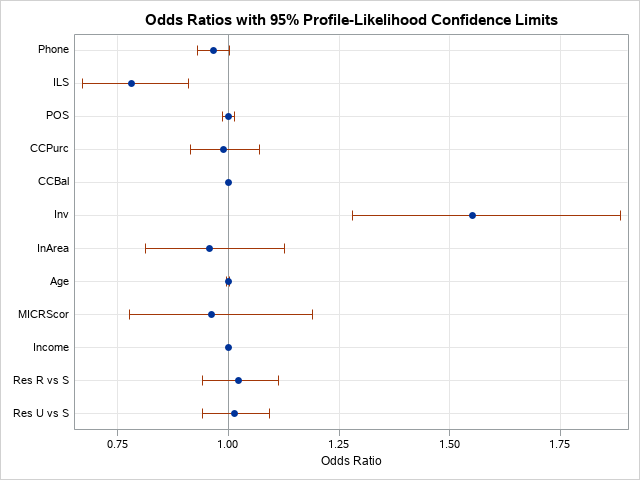

In [19]:
title1 "Interaction Detection using Forward Selection";
proc logistic data=work.train_imputed_swoe_bins;
   class res (param=ref ref='S');
   model ins(event='1')= &screened res
                SavBal|Dep|DDA|CD|Sav|CC|ATM|MM|branch_swoe|Phone|IRA|
                IRABal|B_DDABal|ATMAmt|ILS|POS|NSF|CCPurc|SDB|DepAmt|
                CCBal|Inv|InArea|Age|CashBk|MICRScor|Income|res @2 / include=28 clodds=pl 
       selection=forward slentry=&sl;
run;

Let's look at the output: Interaction Detection using Forward Selection. We have the Model Information table showing our data set, the response variable, number of response levels, the model, and the optimization technique, number of observations read and used. They're both equal, since we imputed our missing values.

We're modeling the probability that Ins equals 1. Here's our Class Level Information table with Res parameterized using reference cell coding, Suburb being the reference level. All these effects will be included in each model.

So the first step looks like the interaction savings balance by binned checking account balance was entered. You want to look at this residual chi-square test. This basically tests the variables not in the model. It looks at the joint significance of the variables not in the model, still highly significant. And then it looks like savings account balance by checking account was entered, and then money market by binned checking account balance was entered.

Rather than looking at each step, let's look at the final results. And it looks like savings balance by binned checking account balance was detected. Savings balance by checking account was detected. Money market by binned checking account balance was detected. The branch smoothed weight of evidence by ATM amount was detected.

All told, there were 21 interactions that were detected using that BIC significance level. Here's our Type 3 Analysis of Effects. We have a number of variables that are obviously important, but we have a number of variables that aren't important.

Here's the Analysis of Maximum Likelihood Estimates, showing all our interactions. Here's the Association of Predicted Probabilities and Observed Responses. We have a c statistic of 0.789, and here's our odds ratio estimates. Only the variables not involved in interaction have odds ratio estimates.

And here's our plot of the odds ratios with 95% confidence intervals. We found 21 interactions, one of the strongest ones being savings account balance by the binned checking account balance. In the next demonstration, we will investigate the interactions in more detail.

#### Practice: Using Forward Selection to Detect Interactions
For the veterans' organization project, use the forward selection method and the BIC-based significance level to detect important two-factor interactions.

Open l3p7.sas in your SAS software. This code defines the ex_screened global macro variable, which contains a list of the input variables in the pmlr.pva_train_imputed_swoe data set that were selected from variable screening in an earlier practice.

In [20]:
%global ex_screened;
%let ex_screened=LIFETIME_GIFT_COUNT LAST_GIFT_AMT MEDIAN_HOME_VALUE 
                 FREQUENCY_STATUS_97NK MONTHS_SINCE_LAST_GIFT  nses_ 
                 mi_DONOR_AGE PCT_MALE_VETERANS PCT_MALE_MILITARY 
                 PCT_WWII_VETERANS LIFETIME_AVG_GIFT_AMT cluster_swoe 
                 PEP_STAR nurbu nurbt home01 nurbr DONOR_AGE STATUS_FL 
                 MOR_HIT_RATE nses4 INCOME_GROUP RECENT_STAR_STATUS 
                 IN_HOUSE WEALTH_RATING nurbs;


Write a PROC SQL step to compute a BIC-based significance level using the sample size for n. Create a global macro variable named sl to store the significance level.

In [21]:
%global sl;

title1 "P-Value for Entry and Retention";
proc sql;
   select 1-probchi(log(sum(target_b ge 0)),1) into :sl
   from pmlr.pva_train_imputed_swoe;
quit;
title1;

What is the value of the BIC-based significance level?
According to the results, the BIC-based significance level is 0.002449.

Use PROC LOGISTIC to detect important two-factor interactions by doing the following:
Fit a logistic regression model to the pmlr.pva_train_imputed_swoe data set with Target_B as the target variable.
Model the probability that Target_B=1.
Specify the input variables from variable screening (performed in a previous demonstration) by referencing the ex_screened macro variable that you created in a previous step.
Use the bar notation for each of the input variables and the @2 notation to specify all input variables and their two-factor interactions.
Specify the forward selection method and include the first 26 input variables.
Specify the BIC-based significance level that you calculated in the previous step.
Specify profile-likelihood confidence intervals.
Set the maximum length of effect names to 50. Use the NAMELEN= option in the PROC LOGISTIC statement.


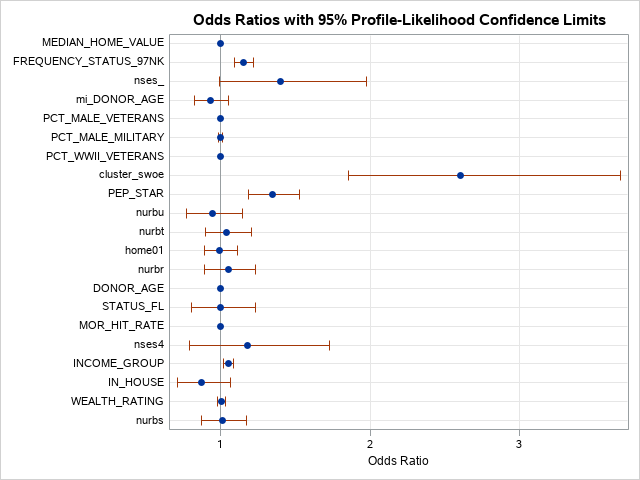

In [22]:
title1 "Interaction Detection using Forward Selection";
proc logistic data=pmlr.pva_train_imputed_swoe namelen=50; /*namelen=50, To avoid errors when you use some versions of SAS/STAT*/
   model target_b(event='1')= &ex_screened 
         LIFETIME_GIFT_COUNT|LAST_GIFT_AMT|MEDIAN_HOME_VALUE|
         FREQUENCY_STATUS_97NK|MONTHS_SINCE_LAST_GIFT|nses_|
         mi_DONOR_AGE|PCT_MALE_VETERANS|PCT_MALE_MILITARY|
         PCT_WWII_VETERANS|LIFETIME_AVG_GIFT_AMT|cluster_swoe|
         PEP_STAR|nurbu|nurbt|home01|nurbr|DONOR_AGE|STATUS_FL|
         MOR_HIT_RATE|nses4|INCOME_GROUP|RECENT_STAR_STATUS|
         IN_HOUSE|WEALTH_RATING|nurbs @2 / include=26 clodds=pl 
       selection=forward slentry=&sl;
run;
title1;

Which interactions were detected?
In the results, the Summary of Forward Selection table shows that the following interactions were detected:
Last_Gift_Amt*Lifetime_Avg_Gift_Amt
Lifetime_Avg_Gift_Amt*Recent_Star_Status
Lifetime_Gift_Count*Months_Since_Last_Gift